In [26]:
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Conv2D,MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from  skimage.transform import resize
from keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import pickle

In [22]:
training_dir="../input/indian-sign-language-dataset/data"
content=sorted(os.listdir(training_dir))
print(content)
len(content)

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


35

In [27]:
data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(training_dir, target_size=(200,200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="training")

validation_generator = data_generator.flow_from_directory(training_dir, target_size=(200, 200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="validation")

Found 37800 images belonging to 35 classes.
Found 4200 images belonging to 35 classes.


In [28]:
inception_v3_model = InceptionV3(
    input_shape = (200, 200, 3),
    include_top=False,
    weights='imagenet'
)


87916544/87910968 [==============================] - 0s 0us/step


In [29]:
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


In [30]:
from tensorflow.keras import layers
x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)                  
x = layers.Dense(35, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [31]:
LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.979

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()


In [33]:
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=200,
    validation_steps=50,
    epochs=5,
    callbacks=[callback]
)


Epoch 1/5
200/200 [==============================] - 224s 1s/step - loss: 0.6304 - acc: 0.9989 - val_loss: 0.2196 - val_acc: 1.0000
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 0.2082 - acc: 1.0000
Reached 97.89999999999999 accuracy, Stopping!
200/200 [==============================] - 199s 993ms/step - loss: 0.2082 - acc: 1.0000 - val_loss: 0.0917 - val_acc: 1.0000


In [ ]:
model.save('transferlearning2.h5')

[0.9989062547683716, 1.0]


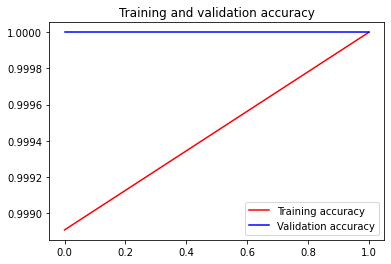

<Figure size 432x288 with 0 Axes>

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()



plt.show()

<Figure size 432x288 with 0 Axes>

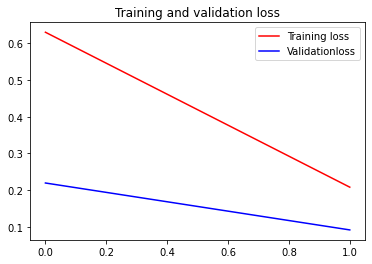

<Figure size 432x288 with 0 Axes>

In [36]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validationloss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()